In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
train_dir = '/content/drive/MyDrive/ChickCheck/train'
val_dir = '/content/drive/MyDrive/ChickCheck/valid'

In [ ]:
import os

total_train = 0


for i in os.listdir(train_dir):
  total_train += len(os.listdir(train_dir+'/'+i))
  print('Total File ', i, '=', len(os.listdir(train_dir+'/'+ i)))

print('Total Train = ', total_train)

total_test = 0

for i in os.listdir(val_dir):
  total_test += len(os.listdir(val_dir+'/'+i))
  print('Total File ', i, '=', len(os.listdir(val_dir+'/'+ i)))

print('Total Val = ', total_test)


total = 0
total = total_train + total_test
print('Total dataset = ', total)

Total File  Salmonella = 500
Total File  Healthy = 500
Total File  Coccidiosis = 500
Total File  New Castle Disease = 480
Total Train =  1980
Total File  Coccidiosis = 100
Total File  Salmonella = 100
Total File  Healthy = 100
Total File  New Castle Disease = 81
Total Val =  381
Total dataset =  2361


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
def view_random_image (target_dir, target_class):
  target_folder = target_dir + target_class
  random_image = random.sample(os.listdir(target_folder),1)

  img = mpimg.imread(target_folder + '/' + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis('off')

  print(f"Ukuran gambar : {img.shape}")
  return img

Ukuran gambar : (224, 224, 3)


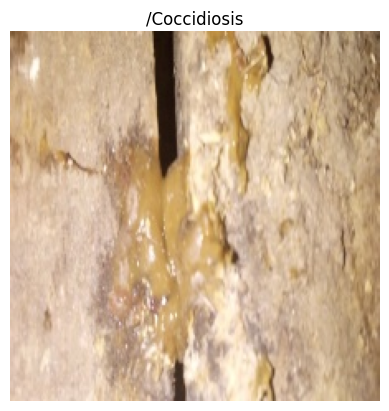

In [ ]:
img = view_random_image (train_dir, '/Coccidiosis')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

training_datagen = ImageDataGenerator(
		rescale = 1./255,
    horizontal_flip=True,
    brightness_range=[0.5, 1.5],
    channel_shift_range=50.0,
		shear_range=0.2,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	train_dir,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=15
)

validation_generator = validation_datagen.flow_from_directory(
	val_dir,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=15
)

Found 1980 images belonging to 4 classes.
Found 381 images belonging to 4 classes.


In [ ]:
# Mendapatkan pelabelan kelas dari generator pelatihan
train_class_indices = train_generator.class_indices
print("Pelabelan kelas dari generator pelatihan:")
print(train_class_indices)

# Mendapatkan pelabelan kelas dari generator validasi
val_class_indices = validation_generator.class_indices
print("\nPelabelan kelas dari generator validasi:")
print(val_class_indices)


Pelabelan kelas dari generator pelatihan:
{'Coccidiosis': 0, 'Healthy': 1, 'New Castle Disease': 2, 'Salmonella': 3}

Pelabelan kelas dari generator validasi:
{'Coccidiosis': 0, 'Healthy': 1, 'New Castle Disease': 2, 'Salmonella': 3}


In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Load the Xception model pre-trained on ImageNet, excluding the top layers
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])

# Print the model summary
model.summary()

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Setup learning rate reduction
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Assuming you have train_data and train_labels as your training data and validation_data, val_labels for validation
# Fit the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[lr_schedule]
)

83683744/83683744 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 21387052 (81.59 MB)
Trainable params: 52557

In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Mengunggah file gambar
uploaded = files.upload()

# Daftar label yang sesuai dengan kelas
class_labels = ['Coccidiosis', 'Healthy', 'New Castle Disease', 'Salmonella']

for fn in uploaded.keys():
    # Path ke file gambar yang diunggah
    path = fn

    # Memuat dan memproses gambar
    img = load_img(path, target_size=(224, 224))  # Sesuaikan dengan ukuran input model Xception
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0  # Normalisasi gambar

    # Melakukan prediksi menggunakan model
    predictions = model.predict(x)

    # Mengambil indeks kelas dengan nilai probabilitas tertinggi
    predicted_class_index = np.argmax(predictions)

    # Menentukan label
    predicted_label = class_labels[predicted_class_index]

    # Menampilkan hasil prediksi
    print('{} is a {}'.format(fn, predicted_label))


Saving salmo.710.jpg to salmo.710.jpg
1/1 [==============================] - 0s 21ms/step
salmo.710.jpg is a Salmonella


Found 781 images belonging to 4 classes.
25/25 [==============================] - 143s 6s/step
Confusion Matrix
[[226   7  10   5]
 [  2 216   5  18]
 [  1   1  24   3]
 [  1  14  11 237]]
Classification Report
                    precision    recall  f1-score   support

       Coccidiosis       0.98      0.91      0.95       248
           Healthy       0.91      0.90      0.90       241
New Castle Disease       0.48      0.83      0.61        29
        Salmonella       0.90      0.90      0.90       263

          accuracy                           0.90       781
         macro avg       0.82      0.88      0.84       781
      weighted avg       0.91      0.90      0.90       781



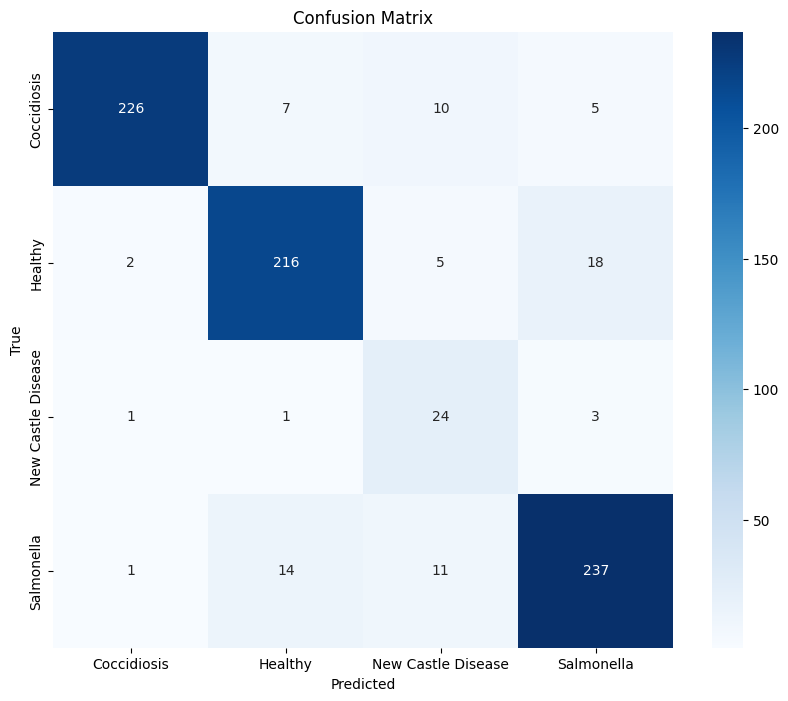

In [ ]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path ke folder test
test_dir = '/content/drive/MyDrive/ChickCheck/test'

# Membuat ImageDataGenerator untuk test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Membuat test data generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False
)

# Melakukan prediksi menggunakan model pada test data
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Mendapatkan label sebenarnya dari test data
true_classes = test_generator.classes

# Mendapatkan label nama kelas dari generator
class_labels = list(test_generator.class_indices.keys())

# Menghitung confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix")
print(cm)

# Menghitung classification report
cr = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report")
print(cr)

# Plotting confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

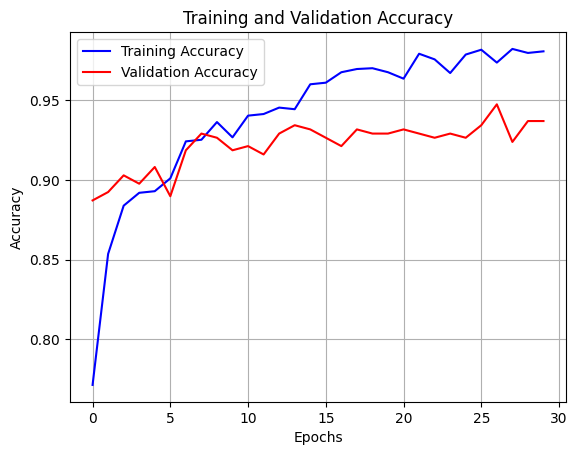

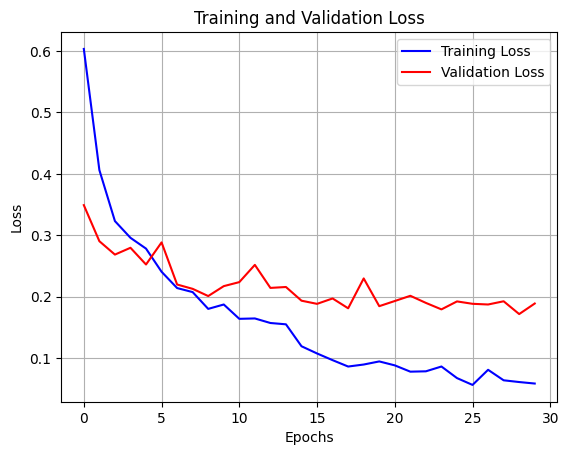

In [ ]:
import matplotlib.pyplot as plt

# Plot akurasi
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
model.save('modelxception.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import tensorflow as tf

# Define the path where the model was saved
destination_path = 'modelxception.h5'

# Load the model
model = tf.keras.models.load_model(destination_path)

# Save the model in the SavedModel format
saved_model_path = '/content/saved_model'
tf.saved_model.save(model, saved_model_path)

print(f"Model saved in SavedModel format at: {saved_model_path}")

Model saved in SavedModel format at: /content/saved_model


In [ ]:
# Convert the TensorFlow model to TensorFlow.js format
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model /content/saved_model /content/tfjs1_model

2024-06-07 05:27:49.259076: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-07 05:27:50.342384: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-06-07 05:27:52.808607: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-07 05:27:52.874696: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. 

In [ ]:
from google.colab import files
import shutil

# Kompres folder tfjs_model menjadi zip
shutil.make_archive('tfjs_model', 'zip', '/content/tfjs1_model')

# Unduh file zip
files.download('tfjs_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>